Stroke Prediction 

In [388]:
import numpy as np
import pandas as pd
import shap
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier

import helper

# Introduction

This project focuses on predicting the likelihood of a stroke using various machine-learning models. Stroke is a significant cause of mortality globally, and early prediction can substantially enhance patient prognosis and survival rates.

The [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) used in this project contains information about individuals, including age, gender, body mass index (BMI), average glucose level, smoking status, and other health-related factors. These features are utilized to train machine learning models to predict an individual's stroke probability.

The project unfolds through several stages, including data cleaning, exploratory data analysis (EDA), hypothesis testing, and machine learning model training. The models used in this project encompass XGBoost, Random Forest, CatBoost, and LightGBM. Their performance is evaluated based on their recall, precision, and F1 score.

A significant challenge in this project was the severe imbalance in the target variable. To address this, we tuned the scale_pos_weight parameter during the hyperparameter tuning stage to optimize the performance of the LightGBM model, which initially showed the best performance.

Model performance evaluation also involved using confusion matrices and ROC curves. These tools offer a comprehensive view of the model's classification capabilities and aid in identifying the optimal classification threshold.

Lastly, we employed SHAP (Shapley Additive explanations) values to gain insights into each feature's contribution to the model's predictions, thereby understanding its significance in predicting stroke likelihood.

The entire initiative is executed in Python, utilizing the capabilities of libraries such as pandas for data manipulation, matplotlib and seaborn for data visualization, scikit-learn for machine learning, and SHAP for model interpretation.

# Review of the data

First of all, we will load the dataset and take a look at the first few rows to understand the data better.

In [389]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [390]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Shape of the dataset.

In [391]:
stroke.shape

(5110, 12)

- Checking the data types of the columns.

In [392]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


We will change the data type of 'hypertension', 'heart_disease', 'stroke' columns to 'object' as they are categorical columns.

In [393]:
stroke[['hypertension', 'heart_disease', 'stroke']] = stroke[['hypertension', 'heart_disease', 'stroke']].astype(
    'object')

In [394]:
num_cols = stroke.select_dtypes(include=['int64', 'float64']).shape[1]

cat_cols = stroke.select_dtypes(include=['object']).shape[1]

print(f"The dataset has {num_cols} numerical columns and {cat_cols} categorical columns.")

The dataset has 4 numerical columns and 8 categorical columns.


The Stroke dataset is relatively small with 5110 rows and 12 columns. The dataset contains 7 numerical columns and 5 categorical columns. Target variable is 'stroke' column and 10 features are given to predict the target variable.

# Data Cleaning

Now, we will check for missing values , duplicates and outliers in the dataset.

- Null values

In [395]:
stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- Duplicates

In [396]:
stroke.duplicated().sum()

0

- Outliers

In [397]:
helper.detect_outliers(stroke, ['age', 'bmi', 'avg_glucose_level'])

Number of outliers in age: 0
Number of outliers in bmi: 110
Number of outliers in avg_glucose_level: 627


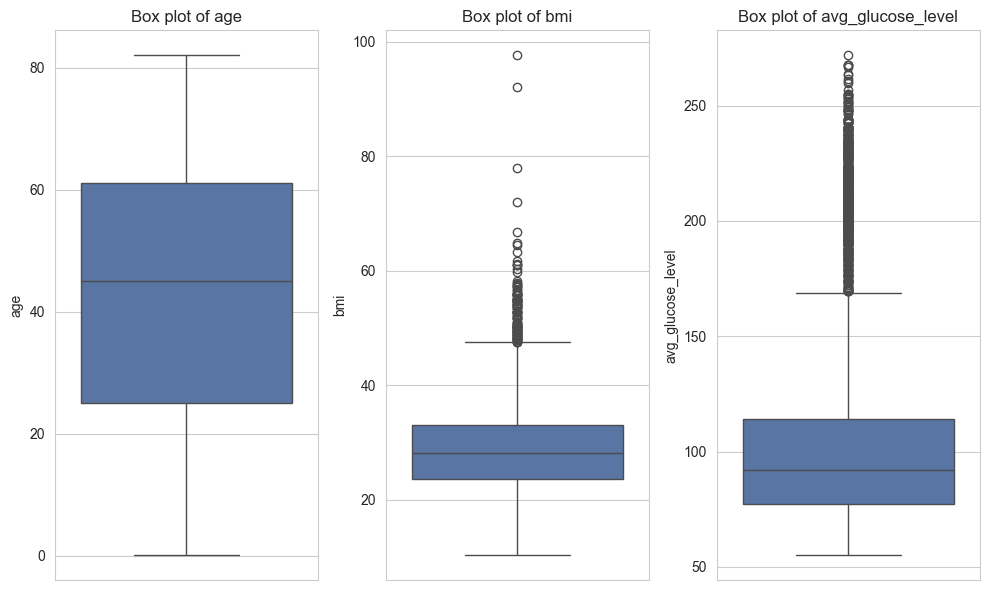

In [398]:
helper.plot_outliers(stroke, ['age', 'bmi', 'avg_glucose_level'])

In our dataset, we've found that the 'bmi' column contains missing values. We've verified that the dataset does not include duplicate entries. Additionally, we've discovered outliers in the 'bmi' and 'avg_glucose_level' columns. We won't eliminate rows with missing values or replace NaN values until we understand the 'bmi' value distribution more deeply. We will also retain the outliers initially and assess the performance of our models with these outliers present.

# Exploratory Data Analysis

## Summary statistics

In [399]:
stroke[['age', 'bmi', 'avg_glucose_level']].describe()

,age,bmi,avg_glucose_level
count,5110.000000,4909.000000,5110.000000
mean,43.226614,28.893237,106.147677
std,22.612647,7.854067,45.283560
min,0.080000,10.300000,55.120000
25%,25.000000,23.500000,77.245000
50%,45.000000,28.100000,91.885000
75%,61.000000,33.100000,114.090000
max,82.000000,97.600000,271.740000


## Data visualization

## Features Distribution

In [400]:
columns = [col for col in stroke.columns if col != 'id']

plot_types = ['count' if stroke[col].dtype == 'object' else 'hist' for col in columns]

plot_specs = list(zip(columns, plot_types))

We will remove row where gender is other as it is only one row.

In [401]:
stroke = stroke[stroke['gender'] != 'Other']

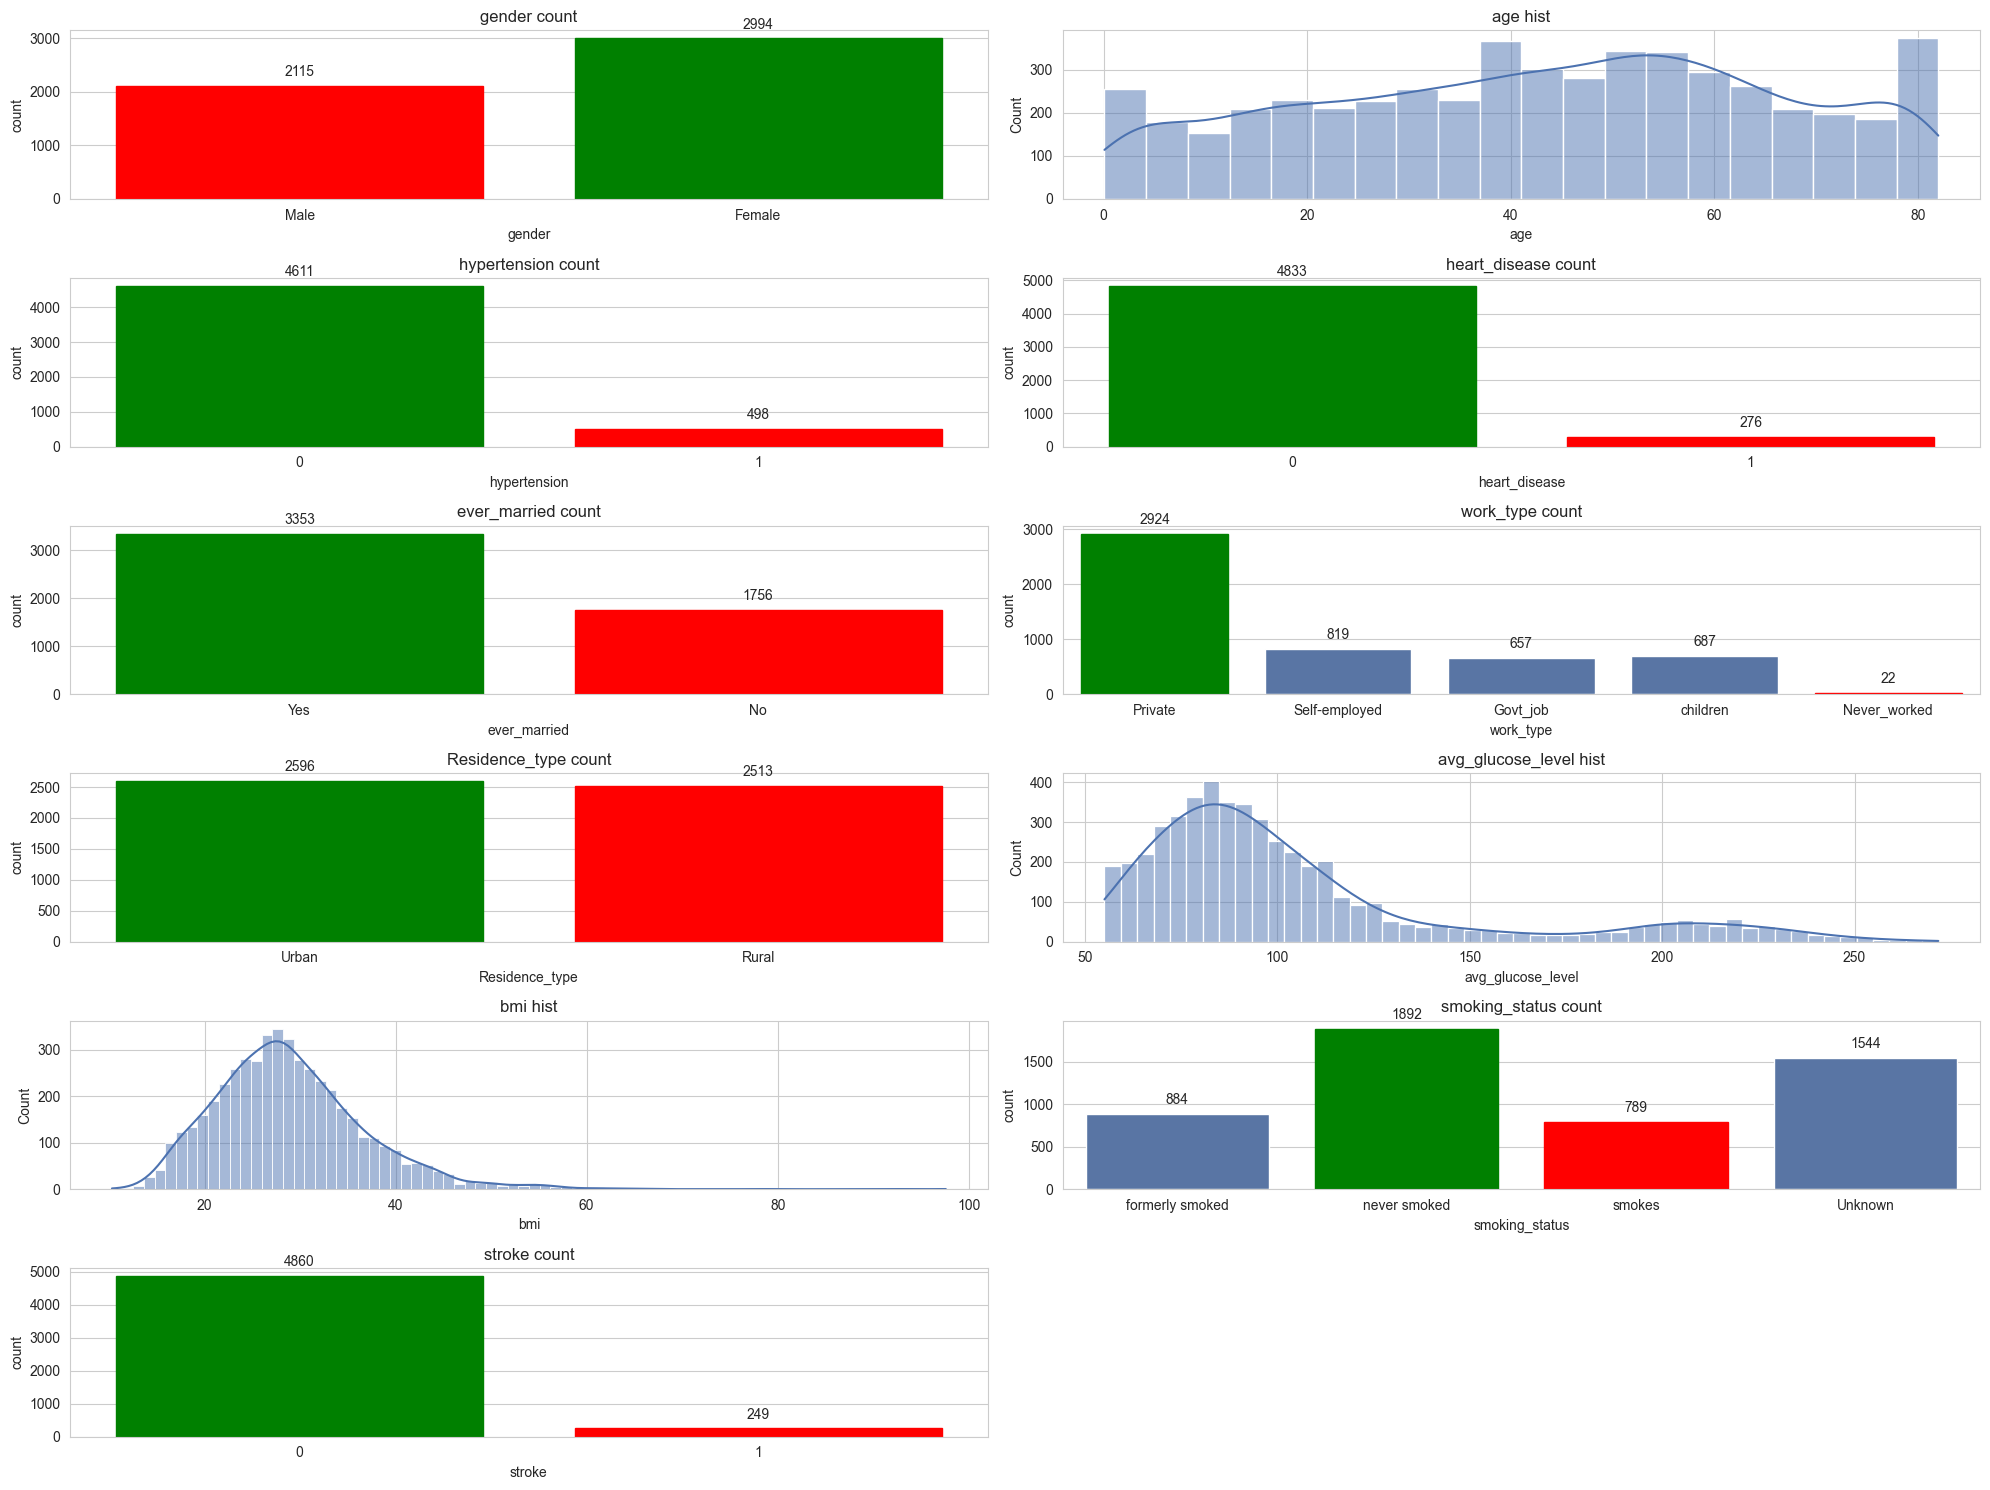

In [402]:
helper.plot_data(stroke, plot_specs)

Based on the information from [Healthline](https://www.healthline.com/health/age-range-for-stroke#stroke-risk-by-age-range), stroke risk factors and probabilities differ across age groups. Let's analyze the distribution of strokes across different ages and other features.

In [403]:
numeric_features = stroke.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = stroke.select_dtypes(include=['object']).columns.tolist()

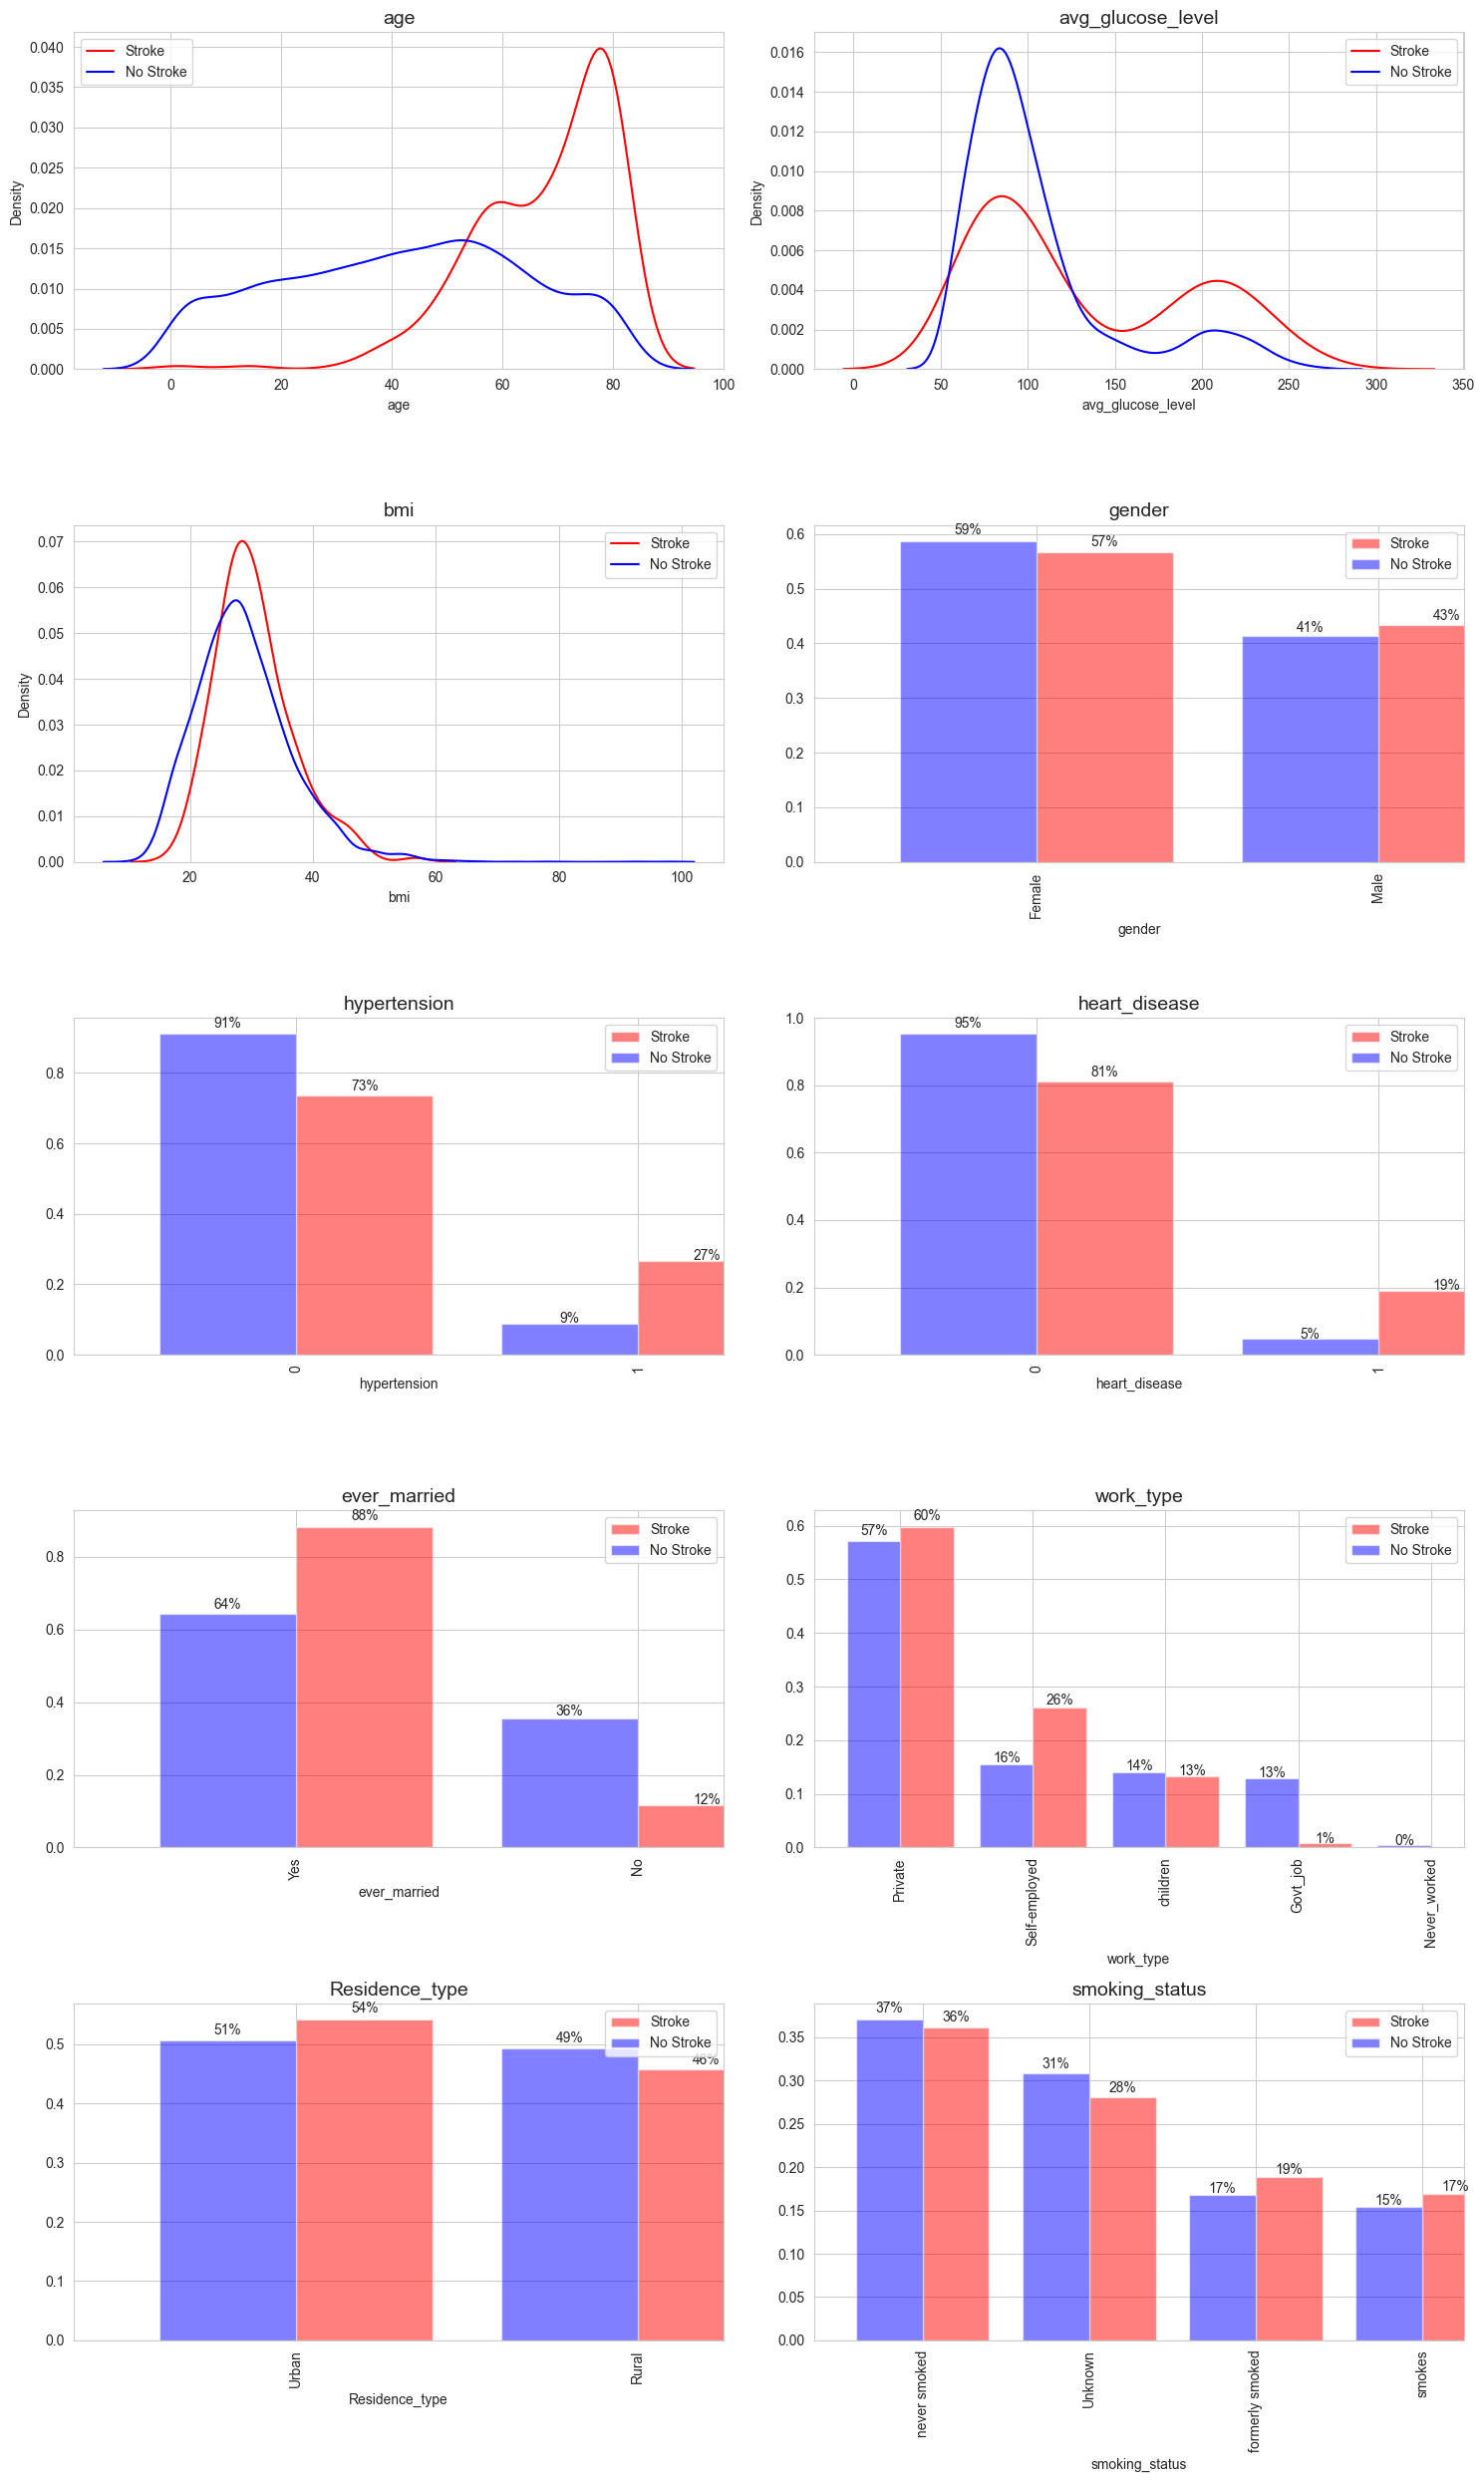

In [404]:
helper.plot_features(stroke, numeric_features, categorical_features, exclude_columns=['id', 'stroke'])

The data visualizations reveal several key insights about the dataset:

1. **Imbalance in Target Variable**: The target variable 'stroke' is highly imbalanced with 249 instances of '1' (indicating stroke) and 4861 instances of '0' (indicating no stroke). This imbalance could affect the performance of a machine-learning model and may need to be addressed during model training.

2. **BMI Distribution**: The 'bmi' feature, excluding outliers, appears normally distributed. This suggests that missing values in the 'bmi' column could be imputed using the mean of the column without significantly affecting the distribution.

3. **Relevance of Features**: The dataset includes features such as smoking status, marital status, and work type that are primarily relevant to adults. This suggests that the dataset is better suited for modeling stroke risk in adults.

4. **Age Distribution and its Implications**: The 'age' feature spans a wide range from 0 to 80s. However, it's crucial to note that the data pertaining to younger age groups may not significantly contribute to the model. This is due to the adult-centric nature of the features, which are more relevant to the risk factors for stroke in adults. Therefore, it's essential to address this potential imbalance to ensure the model's accuracy.

5. **Age and Stroke Risk**: The distribution of strokes across different ages reveals that the risk of stroke increases with age. This observation aligns with the established medical understanding that the risk of stroke escalates with age.

## Correlation 

Our dataset comprises both numerical and categorical data. We will use the Phi-K correlation coefficient to measure the correlation between the features and the target variable. The Phi-K correlation is a robust, entropy-based correlation ratio that works with categorical and numerical variables. It is an extension of the Pearson correlation coefficient, which only works with numerical variables.

The Phi-K correlation coefficient ranges from -1 to 1. A value of 1 indicates a perfect positive correlation, -1 is a perfect negative correlation, and 0 suggests no correlation. In simpler terms, positive values mean that as one variable increases, the other variable tends to increase, while negative values mean that as one variable increases, the other variable tends to decrease.

interval columns not set, guessing: ['age', 'avg_glucose_level', 'bmi']


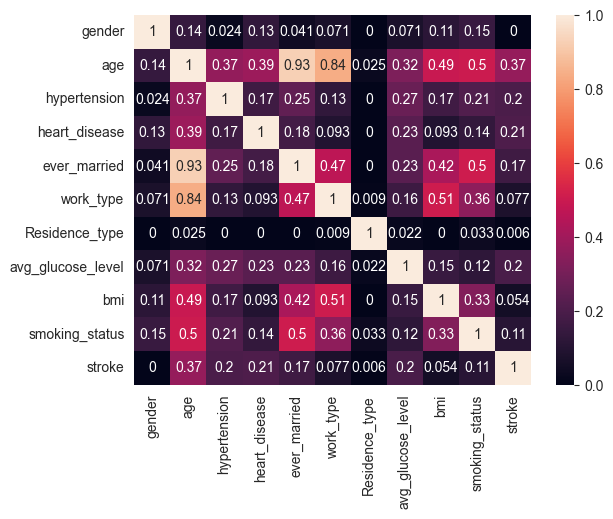

In [405]:
helper.plot_phik(stroke, 'id')

The Phi-K correlation plot offers significant insights into how the features relate to the 'stroke' target variable. Notably, there's a moderate positive correlation between the 'age' feature and the target variable, suggesting an increased stroke risk with advancing age. This observation is consistent with the established medical understanding that the risk of stroke escalates with age.

### Summary of the EDA

During the Exploratory Data Analysis (EDA) phase, we delved into the Stroke dataset, which comprises both numerical and categorical data. A crucial observation was the highly imbalanced nature of the target variable 'stroke'. This imbalance, if not addressed, could potentially impact the performance of our machine learning models, underscoring the importance of this issue in our data analysis process. 

We also found missing values in the 'bmi' column and outliers in the 'bmi' and 'avg_glucose_level' columns. However, we decided to retain these for the initial model training and assess their impact on the model's performance.

After analyzing the data, we observed that the 'age' attribute covers a broad spectrum, ranging from 0.08 to 82. This attribute is particularly significant in predicting strokes. However, considering that the dataset's features, including smoking status, marital status, and work type, are predominantly applicable to adults, we deduced that this dataset is more appropriate for modeling stroke risk in the adult population.

Further, we found that the causes of stroke vary significantly between adults and children. For children aged between 28 days and 18 years, the risk factors include sickle cell diseases, blood clotting disorders, heart and blood vessel problems, and hemorrhagic strokes. On the other hand, for adults, the risk factors are different and are more aligned with the features present in our dataset.

Finally, we used the Phi-K correlation coefficient to measure the correlation between features and target variables. We found a moderate positive correlation between the 'age' feature and the target variable, aligning with the established medical understanding that the risk of stroke escalates with age.

# Hypothesis Testing

- Null Hypothesis (H0): The 'work_type' and 'stroke' are independent, i.e., the work type of an individual does not affect the likelihood of having a stroke.
- Alternative Hypothesis (H1): The 'work_type' and 'stroke' are dependent, i.e., the work type of an individual does affect the likelihood of having a stroke.

The Chi-Square test, a statistical method we will employ, is particularly suited for this hypothesis testing due to its relevance to our variables of interest, 'work_type' and 'stroke'. This test is designed to determine if a significant association exists between two categorical variables in a sample, which aligns perfectly with our research focus. Furthermore, the Chi-Square test assumes that the observations are independent of each other, a condition that is typically met in a dataset where each row represents a different individual. 

The Chi-Square test, known for its accuracy with large sample sizes, is an ideal choice for our dataset, which contains approximately 5000 entries. This test is non-parametric, meaning it does not assume a specific distribution for the variables. This flexibility makes it a versatile tool for hypothesis testing, adapting well to various research scenarios. 

The Chi-Square test is a test of association that can determine if there is a significant association between two categorical variables. In this case, we are interested in understanding if there is an association between 'work_type' and 'stroke'. 

The results of the Chi-Square test will provide us with the following values:

- **Degrees of Freedom**: This value reflects the number of values in the final calculation of a statistic that are free to vary. In the context of a Chi-Square test, it is calculated as (number of rows - 1) * (number of columns - 1) in a contingency table.

- **Critical Value**: This point on the test distribution is compared to the test statistic to determine whether to reject the null hypothesis. The null hypothesis would be rejected if the Chi-Square statistic is greater than the critical value.

- **Chi-Square Statistic**: This is a single number that tells us how much difference exists between our observed counts and the counts we would expect if there were no relationship at all in the population. A more significant Chi-Square statistic corresponds to a tremendous difference between observed and expected counts.

- **P-value**: This is the probability of obtaining the observed data (or more extreme data) if the null hypothesis is true. It's a powerful tool in our statistical arsenal, as a smaller p-value indicates stronger evidence against the null hypothesis. If the p-value is less than 0.05, we reject the null hypothesis.

These results will help us understand the relationship between the variables we are testing and determine whether the observed differences are statistically significant.

In [406]:
helper.perform_chi2_test(stroke, 'work_type', 'stroke')

Degrees of Freedom: 4
Critical Value: 9.488
Chi-Square Statistic: 49.159
P-value: 0.0


The Chi-Square test results indicate a statistically significant association between the 'work_type' and 'stroke' variables. The p-value of 0.0000 is less than the significance level of 0.05, leading us to reject the null hypothesis. This result suggests that the work type of an individual does affect the likelihood of having a stroke.

The data visualization indicates that individuals who are self-employed have a higher risk of experiencing a stroke.

# Machine Learning Models

We will use the following machine learning models to predict the likelihood of stroke based on the given features:

1. **XGBoost Classifier**: XGBoost, short for eXtreme Gradient Boosting, is an ensemble learning method that uses the gradient boosting framework at its core. It operates by building multiple weak prediction models, typically decision trees, and combining them to create a strong predictive model. The "extreme" in XGBoost refers to the model's design to push the limit of computational resources for boosted tree algorithms, which is why it is known for its efficiency and effectiveness in classification tasks. It also includes a regularization parameter to prevent overfitting, which makes it more robust than standard gradient boosting.

2. **Random Forest Classifier**: Random Forest is a versatile ensemble learning method that can be used for both classification and regression tasks. It operates by creating a 'forest' of decision trees, each trained on a random subset of the training data. Each tree in the forest makes a prediction, and the class that gets the most votes becomes the model's prediction. This method is known for its robustness and ability to handle complex, high-dimensional data. It also mitigates the overfitting problem common in single decision trees.

3. **CatBoost Classifier**: CatBoost is a gradient boosting library developed by Yandex. It stands for "Category Boosting", highlighting its high performance and support for categorical features. Like other gradient boosting algorithms, CatBoost combines multiple weak learners to create a strong learner. It has a unique algorithm to handle categorical variables, which can often be challenging for machine learning models. It converts categorical values into numbers using various statistics on combinations of categorical features and their interaction with numerical features.

4. **LightGBM Classifier**: LightGBM, short for Light Gradient Boosting Machine, is a gradient boosting framework developed by Microsoft. It is designed to be fast and efficient, both in terms of computational speed and memory usage. Unlike other gradient boosting algorithms that grow trees horizontally (level-wise), LightGBM grows trees vertically (leaf-wise), choosing the leaf with the maximum delta loss to grow, which can result in better accuracy. It can handle large datasets and deal with the curse of dimensionality better than other models.

We will evaluate the performance of these models using the following metrics:

1. **Recall**: The ability of the model to correctly identify positive samples. It is calculated as the ratio of true positives to the sum of true positives and false negatives.
2. **Precision**: The ability of the model to correctly identify positive samples. It is calculated as the ratio of true positives to the sum of true positives and false positives.
3. **F1 Score**: The harmonic mean of precision and recall. It provides a balance between precision and recall.

We will train the models on the training set, tune the hyperparameters using the validation set, and evaluate the performance on the test set. We will use the recall metric as the primary evaluation metric, as it is crucial to correctly identify individuals at risk of stroke.

Let's start by preparing the data for training the machine learning models.

In [407]:
y = stroke['stroke']

X = stroke.drop(columns=['id', 'stroke'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Preprocessing

We will preprocess the data using the following steps:

1. **Impute missing values**: We will impute missing values using the KNNImputer.
2. **Scale numerical features**: We will scale the numerical features using the StandardScaler.
3. **One-hot encode categorical features**: We will one-hot encode the categorical features using the OneHotEncoder.
4. **Combine preprocessing steps**: We will combine the preprocessing steps using the ColumnTransformer.

In [408]:
numeric_transformer = make_pipeline(
    KNNImputer(n_neighbors=3),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    OneHotEncoder()
)

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Model Selection

In [409]:
models = {
    "XGBClassifier": make_pipeline(preprocessor, XGBClassifier(random_state=42)),
    "RandomForestClassifier": make_pipeline(preprocessor, RandomForestClassifier(random_state=42)),
    "CatBoostClassifier": make_pipeline(preprocessor, CatBoostClassifier(random_state=42, verbose = False)),
    "LGBMClassifier": make_pipeline(preprocessor, LGBMClassifier(random_state=42, verbose=-1)),
}

In [410]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')

final_report = helper.generate_classification_reports(models, X_train, y_train, X_val, y_val)

In [411]:
final_report

precision    recall  f1-score     support
XGBClassifier          0              0.952096  0.981481  0.966565  486.000000
                       1              0.100000  0.040000  0.057143   25.000000
                       accuracy       0.935421  0.935421  0.935421    0.935421
                       macro avg      0.526048  0.510741  0.511854  511.000000
                       weighted avg   0.910408  0.935421  0.922073  511.000000
RandomForestClassifier 0              0.951076  1.000000  0.974925  486.000000
                       1              1.000000  0.000000  0.000000   25.000000
                       accuracy       0.951076  0.951076  0.951076    0.951076
                       macro avg      0.975538  0.500000  0.487462  511.000000
                       weighted avg   0.953470  0.951076  0.927228  511.000000
CatBoostClassifier     0              0.952663  0.993827  0.972810  486.000000
                       1              0.250000  0.040000  0.068966   25.000000
                       accuracy       0.947162  0.947162  0.947162    0.947162
                       macro avg      0.601331  0.516914  0.520888  511.000000
                       weighted avg   0.918286  0.947162  0.928590  511.000000
LGBMClassifier         0              0.954183  0.985597  0.969636  486.000000
                       1              0.222222  0.080000  0.117647   25.000000
                       accuracy       0.941292  0.941292  0.941292    0.941292
                       macro avg      0.588203  0.532798  0.543641  511.000000
                       weighted avg   0.918373  0.941292  0.927953  511.000000

In [412]:
filtered_report = final_report[final_report.index.get_level_values(1).str.contains('1')]
filtered_report

,,precision,recall,f1-score,support
XGBClassifier,1,0.100000,0.04,0.057143,25.0
RandomForestClassifier,1,1.000000,0.00,0.000000,25.0
CatBoostClassifier,1,0.250000,0.04,0.068966,25.0
LGBMClassifier,1,0.222222,0.08,0.117647,25.0


The preliminary assessment of the machine learning models indicates that the LGBMClassifier outperforms others in terms of recall, achieving a score of 0.08. Additionally, it has the highest F1 score of 0.11. Therefore, we will select this model for further hyperparameter tuning to enhance its performance.

# Hyperparameter Tuning

We are set to conduct hyperparameter tuning on the Light Gradient Boosting Machine (LGBM) model. The objective is to optimize the following parameters:

1. `n_estimators`: This parameter determines the number of trees in the forest of the model. The default value is 100. Increasing the number of trees increases the model's performance as it allows the model to learn more complex patterns by adding more decision trees in the ensemble. However, adding too many trees can slow down the training process and, in some cases, can lead to overfitting.

2. `max_depth`: This parameter controls the maximum depth of each tree in the model. The default value is -1, which means no limit. If this parameter is set to a smaller value, it can help to reduce overfitting as it restricts the model from learning very specific details of the training data. However, if it's set too low, the model might underfit the data.

3. `scale_pos_weight`: This parameter is used when you have imbalanced classes. The default value is 1. It's the ratio of the number of negative class to the positive class. Setting it to a value greater than 1 can help improve recall on the minority class as it gives more weight to the minority class.

4. `learning_rate`: This parameter determines the impact of each tree on the final outcome. The default value is 0.1. Lower values make the model more robust to the specific characteristics of each individual tree, thus allowing more iterations, but they increase the risk of overfitting. Higher values make the model more generalized, but they might miss some details in the data.

The goal of tuning these parameters is to identify the combination that yields the highest performance for our LGBM model. Specifically, we aim to enhance the recall score, which is crucial in our context as it measures the model's ability to correctly identify all positive instances.

In [413]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [414]:
scale_pos_weight

19.537688442211056

In [415]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'scale_pos_weight': [scale_pos_weight, 1, 10],
    'learning_rate': [0.1, 0.3, 0.5],
}

grid_search = GridSearchCV(estimator=LGBMClassifier(verbose=-1), param_grid=param_grid, cv=5, scoring='recall')

grid_search.fit(preprocessor.transform(X_train), y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'scale_pos_weight': 19.537688442211056}


In [416]:
best_model = make_pipeline(preprocessor, LGBMClassifier(**best_params, random_state=42))
best_model.fit(X_train, y_train)

y_pred_hyper = best_model.predict(X_val)

best_model_report_dict = classification_report(y_val, y_pred_hyper, output_dict=True, zero_division=1)

best_model_report_df = pd.DataFrame(best_model_report_dict).transpose()

best_model_report_df.index = pd.MultiIndex.from_product([['LGBM HYPERTUNED recall '], best_model_report_df.index])

final_report = pd.concat([final_report, best_model_report_df])

[LightGBM] [Info] Number of positive: 199, number of negative: 3888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 4087, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048691 -> initscore=-2.972345
[LightGBM] [Info] Start training from score -2.972345


In [417]:
filtered_report = final_report[final_report.index.get_level_values(1).str.contains('1')]
filtered_report

,,precision,recall,f1-score,support
XGBClassifier,1,0.100000,0.04,0.057143,25.0
RandomForestClassifier,1,1.000000,0.00,0.000000,25.0
CatBoostClassifier,1,0.250000,0.04,0.068966,25.0
LGBMClassifier,1,0.222222,0.08,0.117647,25.0
LGBM HYPERTUNED recall,1,0.132184,0.92,0.231156,25.0


The hyperparameter tuning process has significantly improved the performance of the LGBM model. The recall score has increased from 0.08 to 0.92,but precision has decreased from 0.22 to 0.13. The F1 score has also improved from 0.11 to 0.23. This enhancement in the recall score is crucial as it indicates the model's ability to correctly identify individuals at risk of stroke.

# Test set evaluation

We will evaluate the performance of the hyperparameter-tuned LGBM model on the test set to assess its generalization ability. This step is crucial to ensure that the model performs well on unseen data and can be deployed in real-world scenarios.

In [418]:
y_test = y_test.astype('int')

y_pred_test = best_model.predict(X_test)

test_report_dict = classification_report(y_test, y_pred_test, output_dict=True, zero_division=1)

test_report_df = pd.DataFrame(test_report_dict).transpose()

test_report_df.index = pd.MultiIndex.from_product([['LGBM HYPERTUNED recall test'], test_report_df.index])

final_report = pd.concat([final_report, test_report_df])

In [419]:
filtered_report = final_report[final_report.index.get_level_values(0).str.startswith('LGBM')]
filtered_report

precision    recall  f1-score  \
LGBMClassifier              0              0.954183  0.985597  0.969636   
                            1              0.222222  0.080000  0.117647   
                            accuracy       0.941292  0.941292  0.941292   
                            macro avg      0.588203  0.532798  0.543641   
                            weighted avg   0.918373  0.941292  0.927953   
LGBM HYPERTUNED recall      0              0.994065  0.689300  0.814095   
                            1              0.132184  0.920000  0.231156   
                            accuracy       0.700587  0.700587  0.700587   
                            macro avg      0.563125  0.804650  0.522625   
                            weighted avg   0.951899  0.700587  0.785575   
LGBM HYPERTUNED recall test 0              0.981928  0.670782  0.797066   
                            1              0.106145  0.760000  0.186275   
                            accuracy       0.675147  0.675147  0.675147   
                            macro avg      0.544036  0.715391  0.491670   
                            weighted avg   0.939081  0.675147  0.767184   

                                             support  
LGBMClassifier              0             486.000000  
                            1              25.000000  
                            accuracy        0.941292  
                            macro avg     511.000000  
                            weighted avg  511.000000  
LGBM HYPERTUNED recall      0             486.000000  
                            1              25.000000  
                            accuracy        0.700587  
                            macro avg     511.000000  
                            weighted avg  511.000000  
LGBM HYPERTUNED recall test 0             486.000000  
                            1              25.000000  
                            accuracy        0.675147  
                            macro avg     511.000000  
                            weighted avg  511.000000

The hyperparameter-tuned LGBM model's evaluation on the test set shows a recall score of 0.76 and a precision score of 0.1. The F1 score is 0.18. Although these results are worse than those on the validation set, the goal of increasing the recall score from 0.08 was successfully achieved.

## Confusion Matrix

A confusion matrix is a tool that helps visualize the performance of a classification model. It's a two-dimensional matrix where each row represents the instances of an actual class and each column represents the instances of a predicted class.

The four outcomes in a confusion matrix are:  
- True Positives (TP): The cases in which the model predicted yes (they have the condition), and they do have the condition.
- True Negatives (TN): The cases in which the model predicted no (they do not have the condition), and they do not have the condition.
- False Positives (FP): The cases in which the model predicted yes, but they do not actually have the condition. Also known as "Type I error".
- False Negatives (FN): The cases in which the model predicted no, but they actually do have the condition. Also known as "Type II error".

In our situation, the primary objective is to minimize False Negatives (FN) because we aim to avoid overlooking individuals who might be at risk of a stroke.

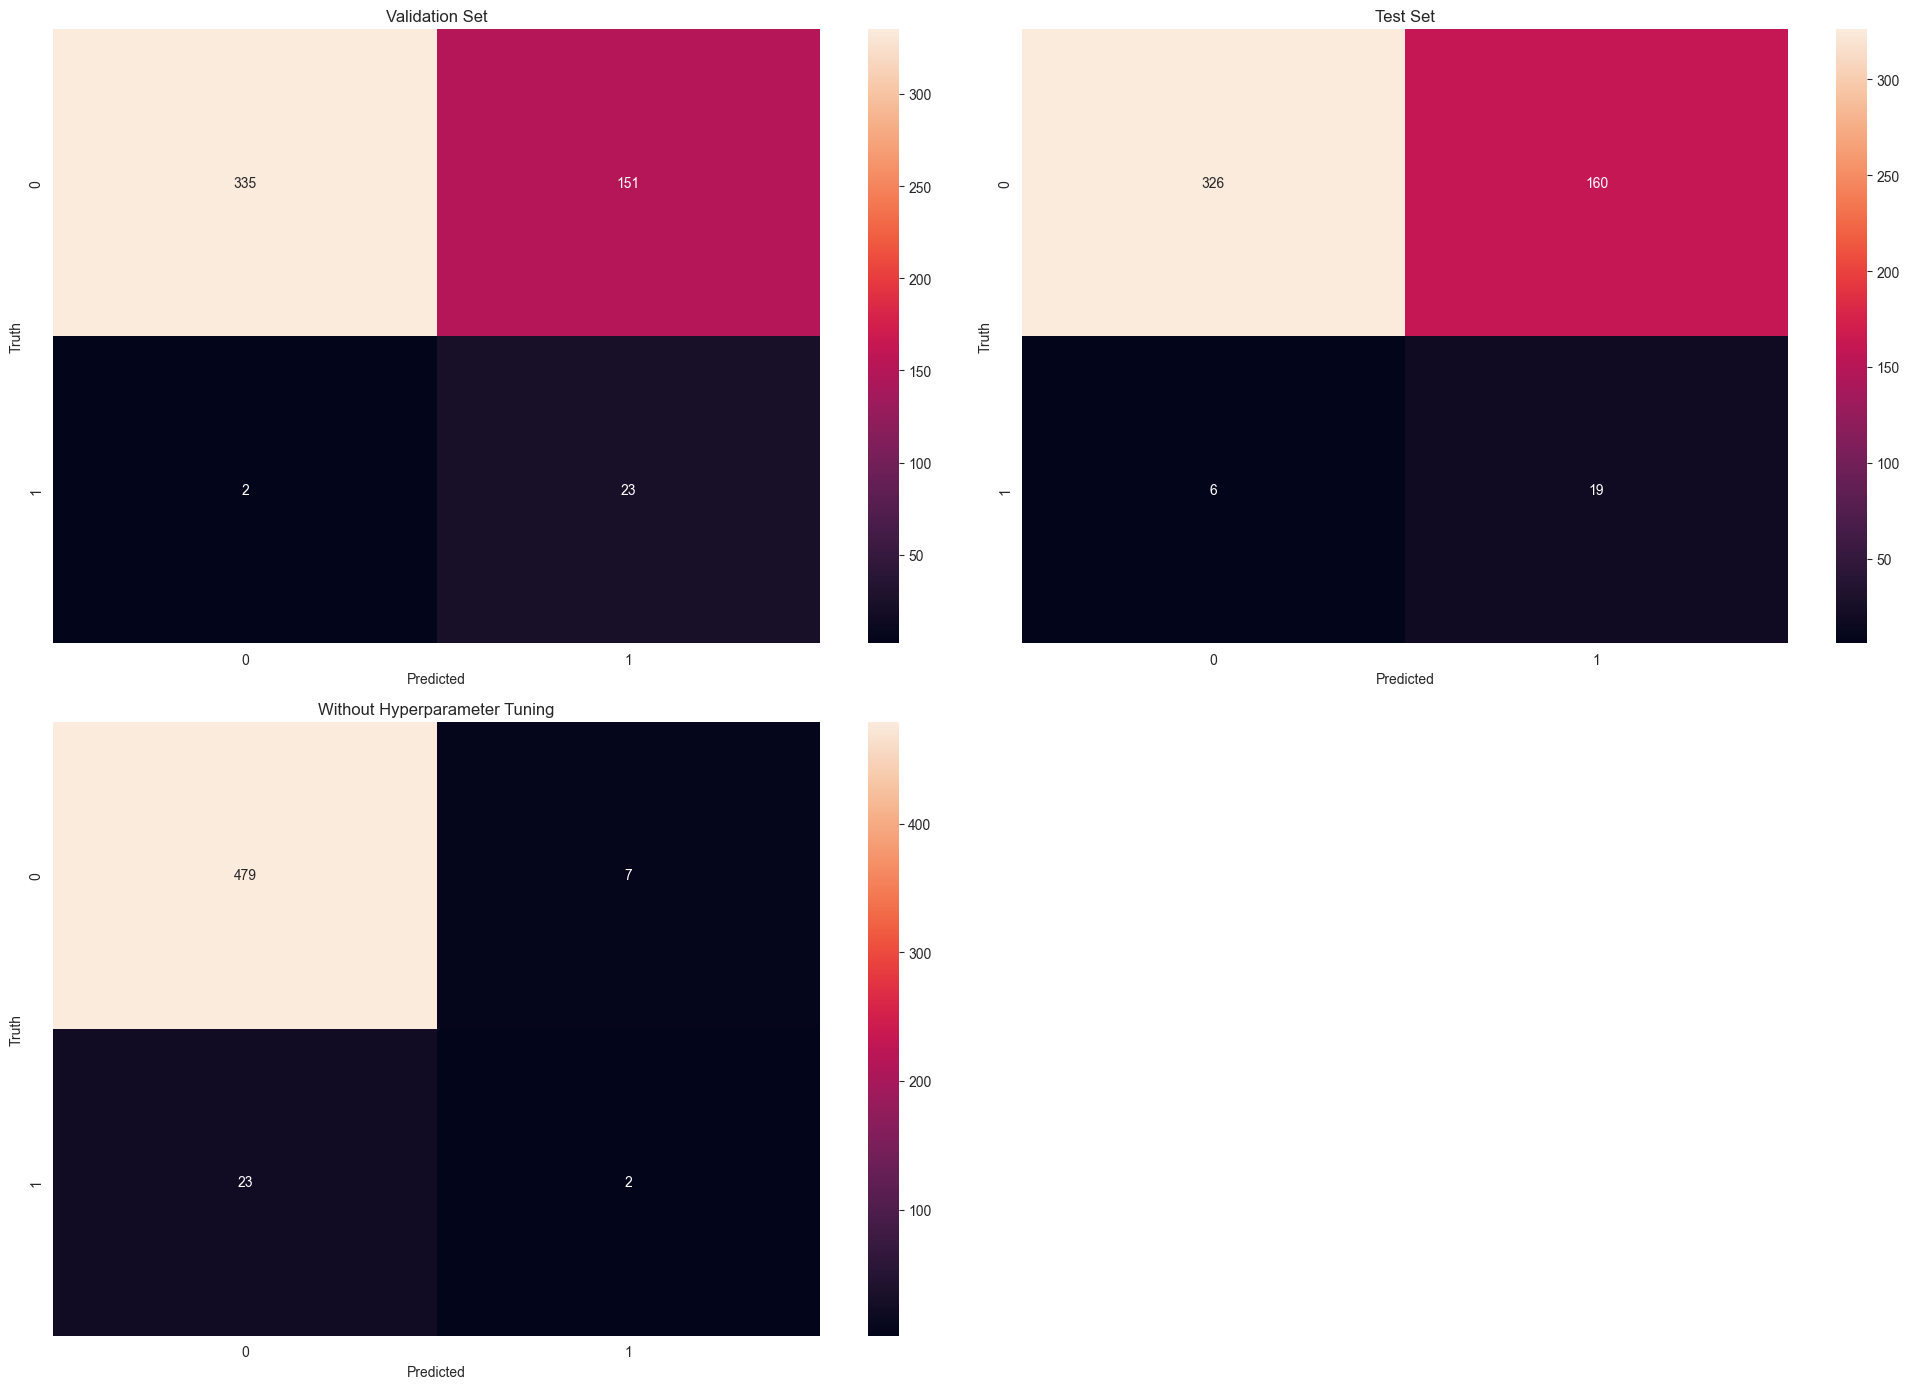

In [420]:
lgbm_model = models["LGBMClassifier"]

y_pred_lgbm = lgbm_model.predict(X_val)

y_true_pred_list = [(y_val, y_pred_hyper), (y_test, y_pred_test), (y_val, y_pred_lgbm)]

title_list = ['Validation Set', 'Test Set', 'Without Hyperparameter Tuning']

helper.plot_multiple_confusion_matrices(y_true_pred_list, titles=title_list)

The hyperparameter-tuned LGBM model exhibits a significant reduction in False Negatives compared to the model without hyperparameter tuning. Also, it has a higher True Positive rate. This indicates that the model better identifies individuals at risk of stroke. However, the False Positive rate has increased, which means the model incorrectly predicts more individuals at risk of stroke. This trade-off between False Positives and False Negatives is crucial in stroke prediction, as it determines the model's ability to identify individuals at risk correctly.

## ROC Curve

The Receiver Operating Characteristic (ROC) curve is a graphical tool used to assess the performance of a classifier. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. Each point on the ROC curve represents a different threshold value.

The Area Under the Curve (AUC) is a metric that quantifies the classifier's overall performance. It ranges from 0 to 1, with 1 indicating perfect discrimination and 0.5 indicating no better discrimination than random guessing.

When we plot the ROC curve and calculate the AUC score for a model, we aim to visualize its ability to distinguish between classes and identify the optimal classification threshold. The closer the curve is to the top left corner, the higher the AUC score, the better the model's performance. The ROC curve and AUC score provide a comprehensive view of the model's performance across all thresholds.

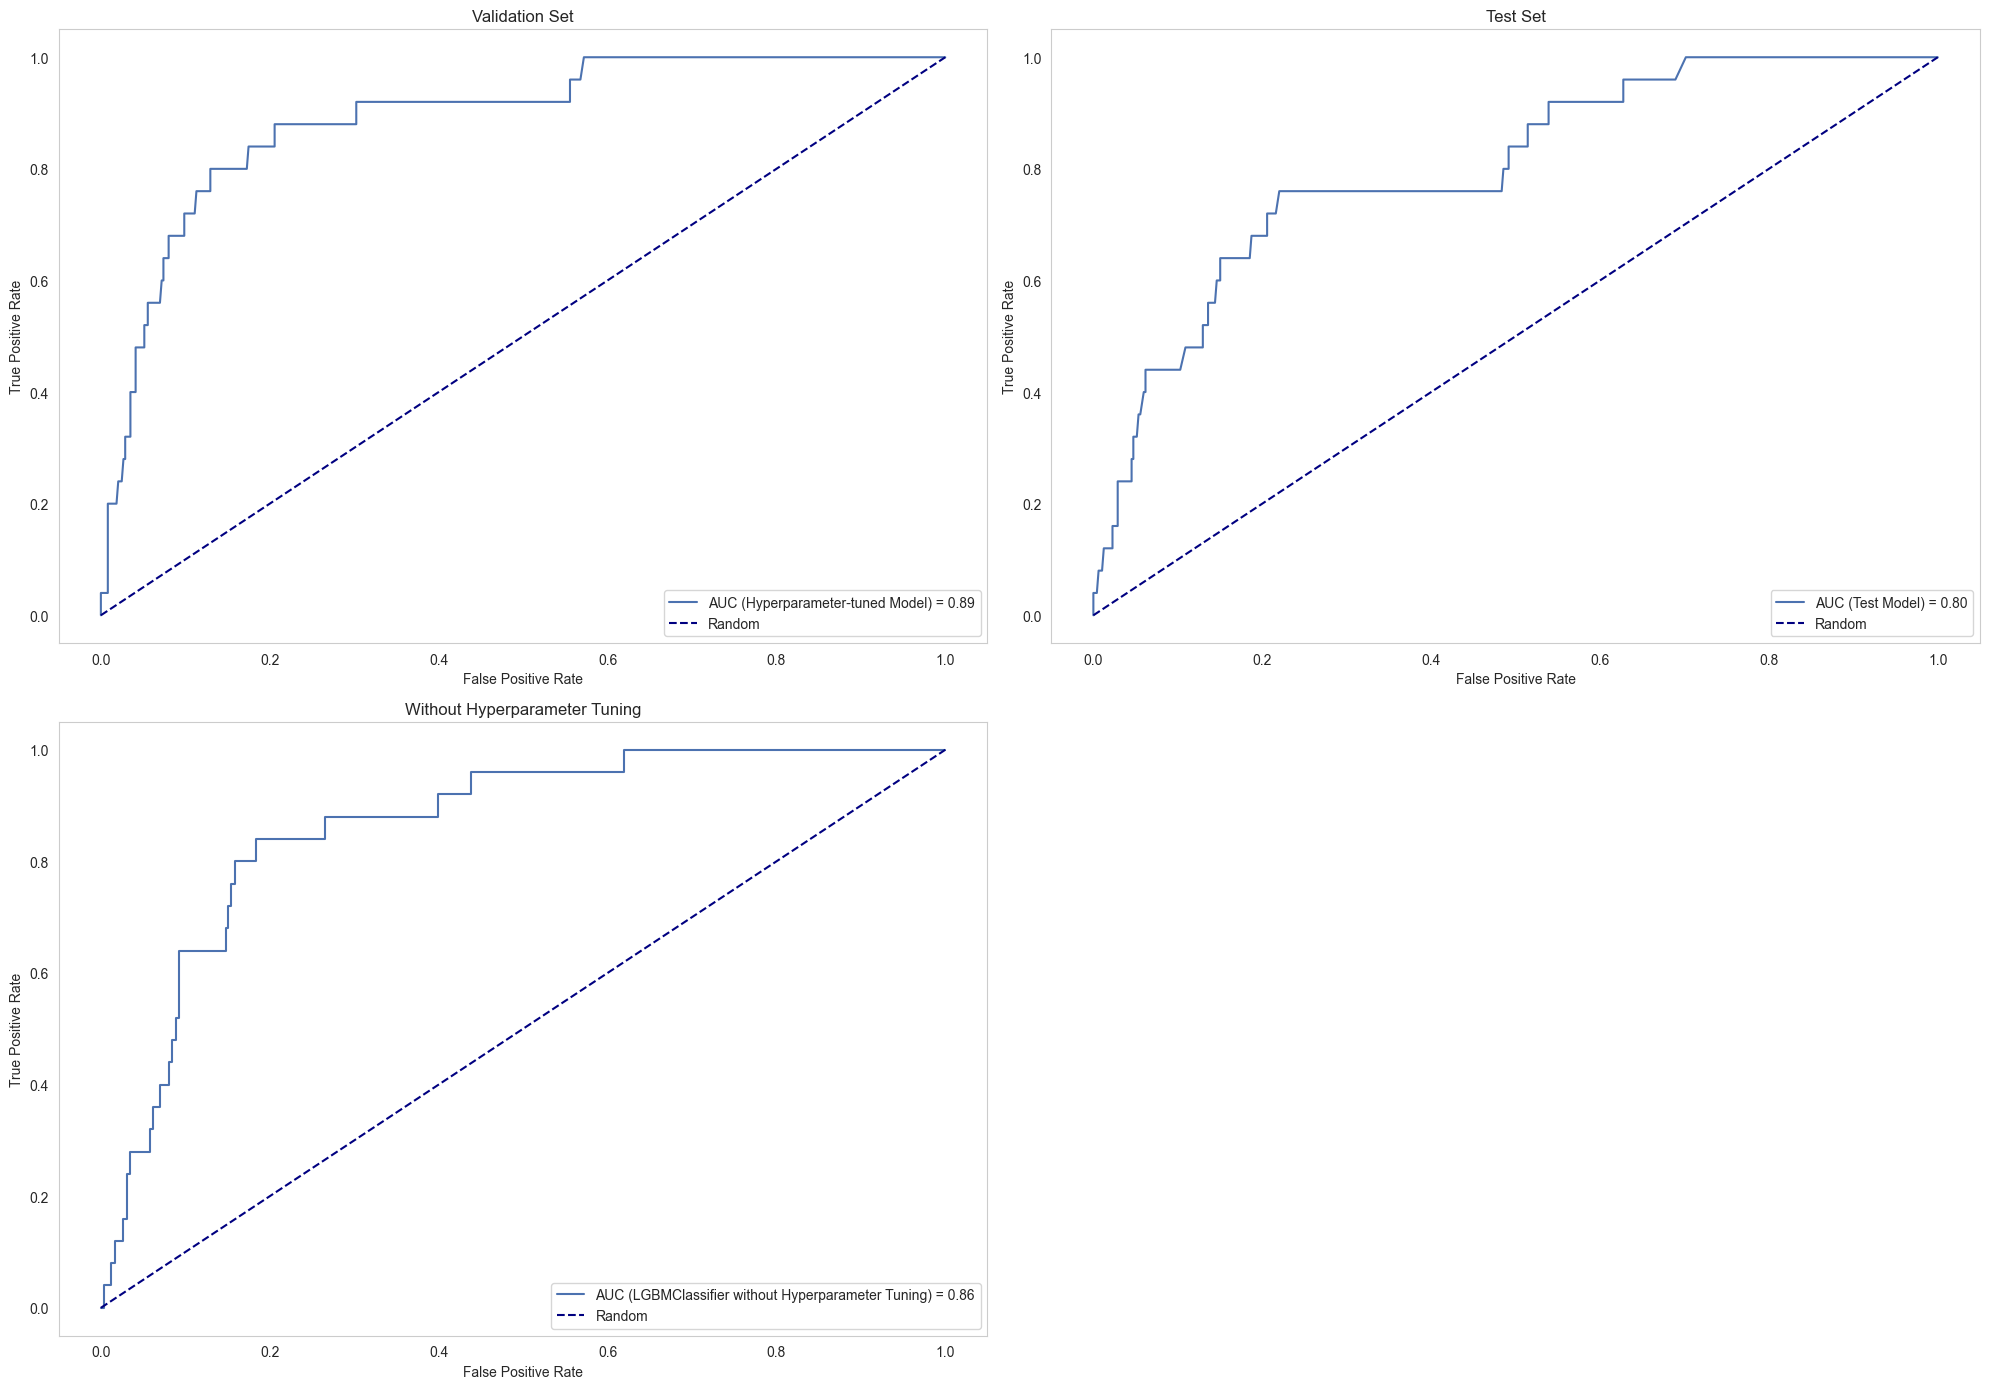

In [421]:
models_list = [best_model, best_model, lgbm_model]
model_names_list = ['Hyperparameter-tuned Model', 'Test Model', 'LGBMClassifier without Hyperparameter Tuning']
X_tests_list = [X_val, X_test, X_val]
y_tests_list = [y_val, y_test, y_val]

helper.plot_multiple_roc_curves(models_list, model_names_list, X_tests_list, y_tests_list, titles=title_list)

## SHAP Values

SHAP (Shapley Additive explanations) is a way to understand how a machine learning model makes predictions. It uses ideas from game theory to explain how each feature contributes to a prediction.

SHAP values show how much a feature changes a prediction compared to if the feature was a basic or default value. They help us see how the model makes its predictions and show us which features are important in making these predictions.

Through the visual representation of SHAP values, we can embark on a visual journey, gaining a deeper understanding of the model's decision-making process. This visual exploration unveils the features that wield the most influence over the model's predictions.

We will calculate and show the SHAP values for our tuned LGBM model. This will help us understand how it makes predictions and see which features are important in predicting the chance of a stroke.

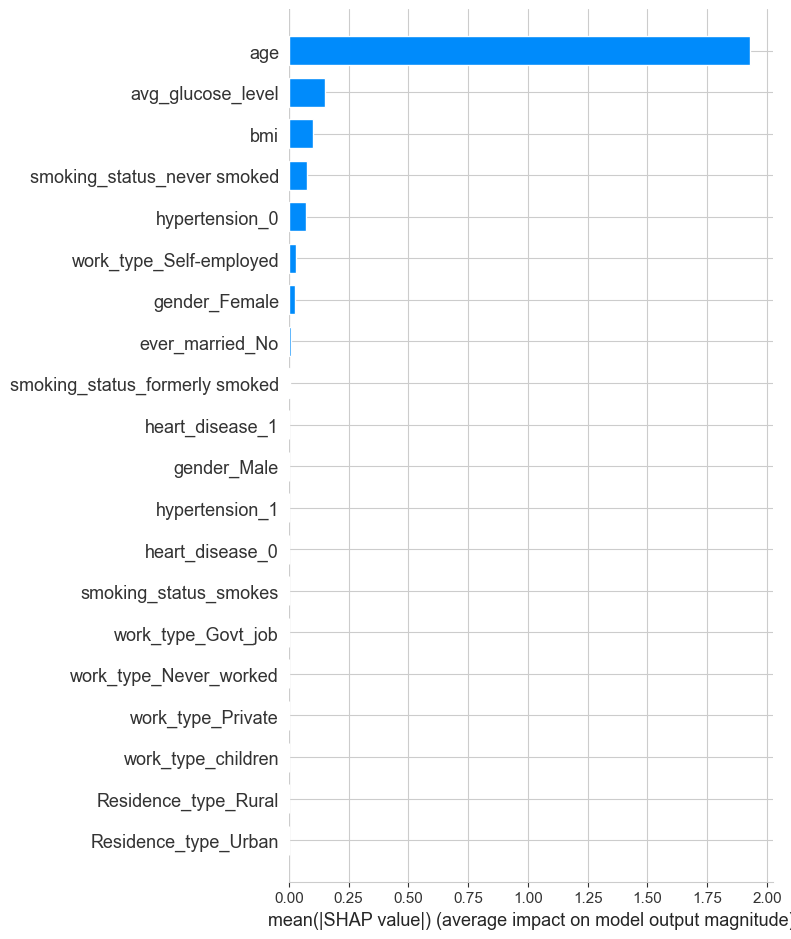

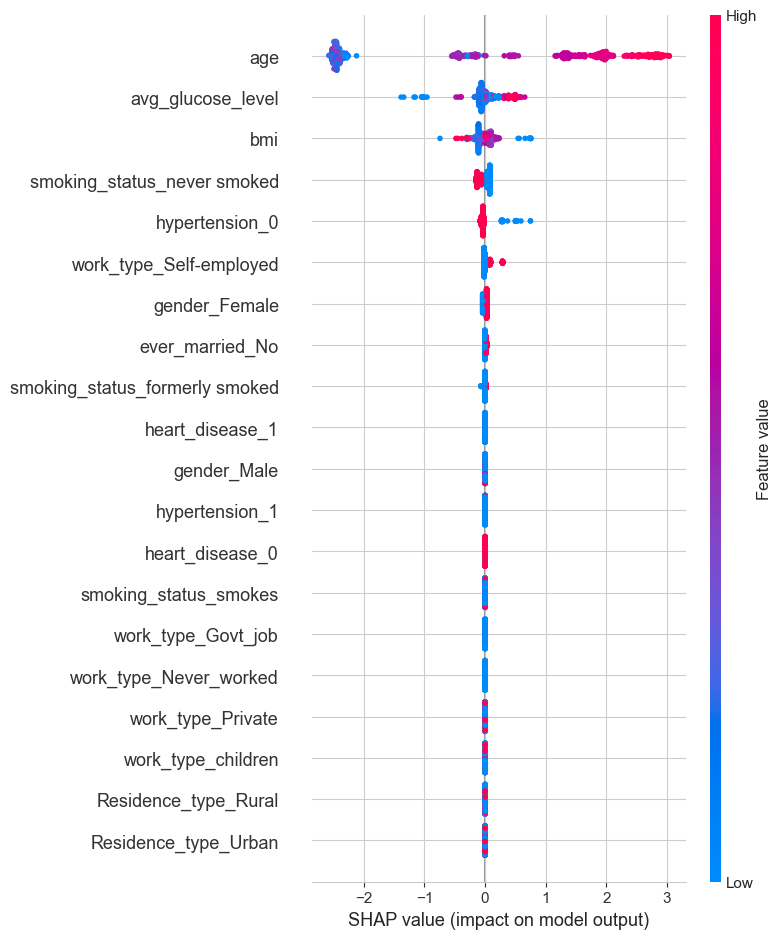

In [422]:
X_val_preprocessed = preprocessor.transform(X_val)

explainer = shap.Explainer(best_model.named_steps['lgbmclassifier'])

shap_values = explainer(X_val_preprocessed)

feature_names = preprocessor.named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out(
    categorical_features)
feature_names = np.concatenate([numeric_features, feature_names])

shap.summary_plot(shap_values, X_val_preprocessed, feature_names=feature_names, plot_type='bar')
shap.summary_plot(shap_values, X_val_preprocessed, feature_names=feature_names)

The SHAP summary plot highlights the main features affecting the model's predictions. The 'age' attribute stands out as the most critical determinant in forecasting the probability of a stroke. Other notable attributes such as 'avg_glucose_level,' 'bmi,' and 'hypertension' also significantly contribute to the model's decision-making, underlining their importance in assessing an individual's stroke risk.

## Distribution of Classification Scores

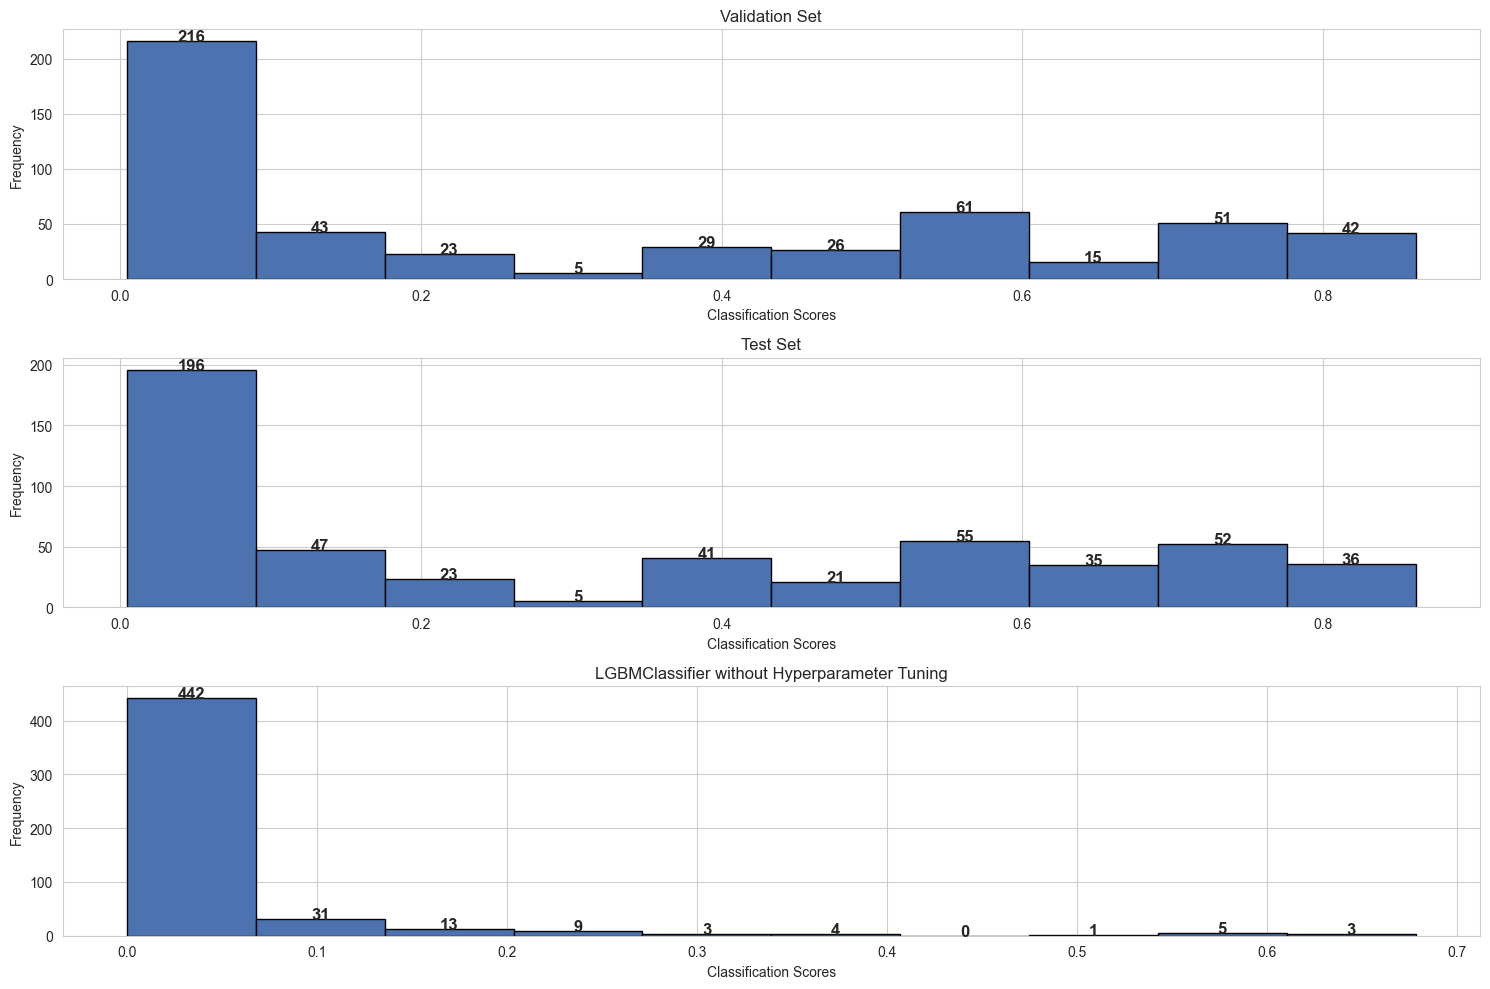

In [423]:
y_lgbm = lgbm_model.predict_proba(X_val)[:, 1]
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_test_proba = best_model.predict_proba(X_test)[:, 1]

helper.plot_classification_distribution([y_val_proba, y_test_proba, y_lgbm],
                                        ['Validation Set', 'Test Set', 'LGBMClassifier without Hyperparameter Tuning'],
                                        figsize=(15, 10))

The distribution of classification scores changed significantly with the hyperparameter-tuned LGBM model. Many scores that were previously 0 have increased, allowing the model to identify more instances of strokes. However, this improvement comes with an increase in false positives.

# Conclusion

Our project was driven by the primary goal of predicting stroke likelihood, a critical health risk, using a robust selection of machine-learning models. We leveraged the power of XGBoost, Random Forest, CatBoost, and LightGBM models, each chosen for their unique strengths. The performance of these models was rigorously evaluated based on their recall, precision, and F1 score, ensuring the reliability of our findings.

The most significant challenge during this project was the severe imbalance in the target variable. To address this, we tuned the `scale_pos_weight` parameter during the hyperparameter tuning stage to optimize the performance of the LightGBM model, which initially showed the best performance.

The hyperparameter tuning process was a pivotal moment for our LGBM model, significantly elevating its recall score from 0.08 to an impressive 0.92 on the validation and 0.76 on the test sets. This marked improvement underscores the effectiveness of our approach and the potential for further optimization, enhancing the model's ability to identify individuals at risk of stroke.

However, it's important to note that this boost in recall was accompanied by a decrease in precision. While the model became more adept at identifying individuals at risk of stroke, it also made more false optimistic predictions. This trade-off between recall and precision, a key consideration in machine learning, should be carefully weighed when interpreting the results, providing a balanced view of the model's strengths and limitations.

The SHAP summary plot revealed that 'age' was the most influential feature in predicting stroke likelihood. Other significant features included 'avg_glucose_level,' 'bmi,' and 'hypertension.' These insights can be valuable for healthcare professionals in identifying high-risk individuals and taking preventive measures.

In addition to the methods documented in this project, other strategies were explored but have yet to be included here. For example, an attempt was made to train the model exclusively on adults aged 45 and above, given that the incidence of strokes increases from this age. When trained on this subset, the hyper-tuned model demonstrated a similar recall but a higher precision. This could suggest that this dataset is more effective for identifying strokes in adults, and data from children and young adults might introduce noise. However, more data collection would be required to validate this assertion, as selecting an age of 45+ led to the removal of half of the training data. An experiment was also conducted with age categorization, but it did not enhance the model's performance.

Overall, this project demonstrates the potential of machine learning in healthcare, particularly in predicting health risks such as stroke. However, it also highlights the challenges and considerations in developing and interpreting machine learning models, such as dealing with imbalanced data and understanding the trade-off between recall and precision.

# Suggestions for improvment

The analysis can be improved in several ways:

1. **Data Collection**: More data, especially for the minority class (stroke cases), could improve the model's performance. Additionally, collecting more data for different age groups, particularly for adults aged 45 and above, could help validate the hypothesis that the dataset is better suited for identifying strokes in adults.

2. **Feature Engineering**: Experiment with creating new features relevant to the prediction. For example, you could make a feature that combines age and hypertension, as both are significant risk factors for stroke.

3. **Model Experimentation**: Try different machine learning models or ensemble methods. Neural networks or stacking multiple models may yield better results.

4. **Threshold Adjustment**: Since the problem at hand is a medical one and false negatives could have serious implications, adjusting the threshold for classification could lead to better recall results.

5. **Conformal Prediction**: Conformal prediction is a technique that measures confidence in predictions. In the context of stroke prediction, it could be beneficial to know the confidence of the prediction. This could be achieved by implementing a conformal prediction framework, which would provide a prediction interval for each prediction, indicating its reliability.